## What are the features in this data?
* Each instance is a school.

## Graduation rate is given by two features--Cohort and Rate--for each subpopulation below.
* Cohort - Number of students in that subpopulation
* Rate - Percentage (or range of percentage) of students in the cohort graduating with a high school diploma within 4 years

## School identifiers
* STNAM  - State name
* FIPST  - 2 digit code for the state
* LEANM  - School district name
* LEAID  - 7 digit code for school district 
* SCHNAM - School name
* NCESSH - 12 digit school id (only unique identifier for a school)


## Subpopulations
* ALL 	= All students in the school
* MAM 	= American Indian/Alaska   Native students
* MAS 	= Asian/Pacific Islander students
* MHI 	= Hispanic students
* MBL 	= Black students
* MWH 	= White students
* MTR 	= Two or More Races
* CWD 	= Children with Disabilities (IDEA)
* ECD 	= Economically Disadvantaged students
* LEP 	= Limited English Proficient students


In [212]:
import sys
sys.path.append("..")
from ingest import gr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swampy import structshape as ss

In [213]:
dfs = [gr.make_raw_gr_frame(year=y) for y in range(2010, 2019)]
years = [gr.year_string(y) for y in range(2010, 2019)]


In [214]:
# Many of the column names have the school year in them, which presents a challenge for combining all the years
# into one large dataframe.
print(dfs[0].columns)


Index(['STNAM', 'FIPST', 'LEAID', 'LEANM', 'NCESSCH', 'SCHNAM',
       'ALL_COHORT_1011', 'ALL_RATE_1011', 'MAM_COHORT_1011', 'MAM_RATE_1011',
       'MAS_COHORT_1011', 'MAS_RATE_1011', 'MBL_COHORT_1011', 'MBL_RATE_1011',
       'MHI_COHORT_1011', 'MHI_RATE_1011', 'MTR_COHORT_1011', 'MTR_RATE_1011',
       'MWH_COHORT_1011', 'MWH_RATE_1011', 'CWD_COHORT_1011', 'CWD_RATE_1011',
       'ECD_COHORT_1011', 'ECD_RATE_1011', 'LEP_COHORT_1011', 'LEP_RATE_1011',
       'DATE_CUR'],
      dtype='object')


### Reshaping the data from different years to so that they can be combined into one large dataset. 

In [215]:
shape_data = [(school_year, df.shape) for school_year, df in zip(years, dfs)]
shape = pd.DataFrame(shape_data, columns=('school_year', 'shape'))
shape


,school_year,shape
0,1011,"(21335, 27)"
1,1112,"(21244, 27)"
2,1213,"(22077, 27)"
3,1314,"(22385, 28)"
4,1415,"(22167, 27)"
5,1516,"(23090, 27)"
6,1617,"(23129, 29)"
7,1718,"(23240, 33)"
8,1819,"(22900, 33)"


In [216]:
# Inspect features that are present in some but not common to all.
# Start by removing the years from the column names.
# cols_wo_year => Column names without the year
cols_wo_year = [list(map(lambda x: x.replace(y, ""), df.columns))
                for y, df in zip(years, dfs)]
print(set(cols_wo_year[3]) - set(cols_wo_year[0]))
print(set(cols_wo_year[6]) - set(cols_wo_year[0]))
print(set(cols_wo_year[7]) - set(cols_wo_year[0]))
print(set(cols_wo_year[8]) - set(cols_wo_year[0]))


{'INSERT_DATE'}
{'ST_LEAID', 'ST_SCHID'}
{'FCS_RATE_', 'FCS_COHORT_', 'ST_LEAID', 'ST_SCHID', 'HOM_RATE_', 'HOM_COHORT_'}
{'FCS_RATE_', 'FCS_COHORT_', 'ST_LEAID', 'ST_SCHID', 'HOM_RATE_', 'HOM_COHORT_'}


In [217]:
# INSERT_DATE refers to when the data was inserted and is not relevant for our study.
dfs[3].drop(['INSERT_DATE'], axis=1, inplace=True)
# ST_SCHID and ST_LEAID are values assigned by the state which are not found in the other years. From the data, it looks like maybe these
# started being assigned in 2016. If we need another geographical grouping mechanism in the future we can look into it.
dfs[6].drop(['ST_LEAID', 'ST_SCHID'], axis=1, inplace=True)
# HOM_COHORT and FCS_COHORT refer to the subpopulation of homeless and foster care students, which was not tracked before school year 2017-2018
idx7_sr = shape.school_year[7]
idx8_sr = shape.school_year[8]
dfs[7].drop(['ST_LEAID', 'ST_SCHID', 'FCS_RATE_'+idx7_sr, 'FCS_COHORT_'+idx7_sr,
            'HOM_RATE_'+idx7_sr, 'HOM_COHORT_'+idx7_sr], axis=1, inplace=True)
dfs[8].drop(['ST_LEAID', 'ST_SCHID', 'FCS_RATE_'+idx8_sr, 'FCS_COHORT_'+idx8_sr,
            'HOM_RATE_'+idx8_sr, 'HOM_COHORT_'+idx8_sr], axis=1, inplace=True)


In [218]:
# Verify that all dataframes have the same columns (minus the school year) before we combine.
cols_wo_school_year = [list(map(lambda x: x.replace(y, ""), df.columns))
                       for y, df in zip(years, dfs)]
for num1, num2 in zip(range(0, 8), range(1, 9)):
    assert cols_wo_school_year[num1] == cols_wo_school_year[num2]


In [219]:
big_df = pd.DataFrame()
print("big_df_columns", big_df.columns)
for idx, df in enumerate(dfs):
    df.columns = cols_wo_school_year[0]
    df['Year'] = years[idx]
    # reorder columns to be how we want
    df = df[['Year']+cols_wo_school_year[0]]
    big_df = pd.concat([big_df, df], axis=0)


big_df_columns Index([], dtype='object')


In [220]:
big_df.shape, big_df.head(n=3)


((201567, 28),
    Year    STNAM  FIPST   LEAID             LEANM      NCESSCH  \
 0  1011  ALABAMA      1  100005  Albertville City  10000500871   
 1  1011  ALABAMA      1  100006   Marshall County  10000600872   
 2  1011  ALABAMA      1  100006   Marshall County  10000600878   
 
                  SCHNAM ALL_COHORT_ ALL_RATE_ MAM_COHORT_  ... MTR_RATE_  \
 0  Albertville High Sch         252        80           .  ...         .   
 1            Asbury Sch          57     70-79           .  ...         .   
 2      Douglas High Sch         125     65-69           2  ...         .   
 
   MWH_COHORT_ MWH_RATE_ CWD_COHORT_ CWD_RATE_ ECD_COHORT_ ECD_RATE_  \
 0         184     80-84           3        PS         121     65-69   
 1          48     70-79           7      GE50          31     60-69   
 2         105     70-74          13      GE50          92     60-64   
 
   LEP_COHORT_ LEP_RATE_ DATE_CUR  
 0          10      LT50  03OCT15  
 1           3        PS  03OCT15  
 2     

In [221]:
df_info = pd.DataFrame(columns=['% Null', '% Unique'])
df_info['% Null'] = big_df.isnull().sum() / len(big_df) * 100
df_info['% Unique'] = big_df.nunique() / len(big_df) * 100
df_info


,% Null,% Unique
Year,0.000000,0.004465
STNAM,0.000000,0.026790
FIPST,0.000000,0.026294
LEAID,0.000000,6.747136
LEANM,0.000000,7.671395
NCESSCH,0.000000,14.401167
SCHNAM,0.000000,15.943582
ALL_COHORT_,0.000000,1.121215
ALL_RATE_,0.000000,0.067967
MAM_COHORT_,24.116547,0.157764


Text(0, 0.5, '% Null')

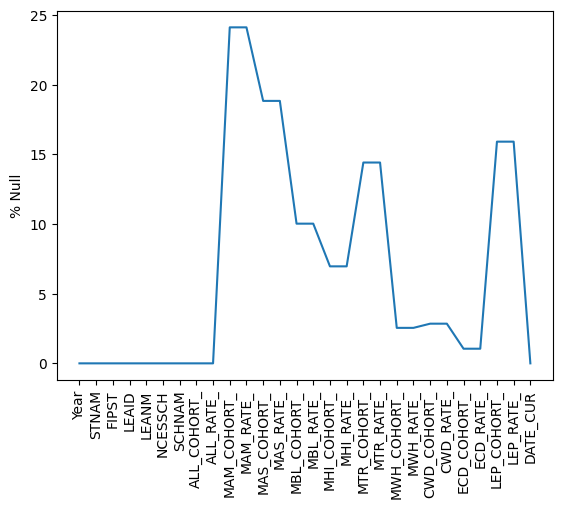

In [222]:
plt.plot(range(big_df.columns.size),
         (big_df.isnull().sum() / len(big_df) * 100).values)
plt.xticks(ticks=list(range(big_df.columns.size)),
           labels=big_df.columns.tolist(), rotation=90)
plt.ylabel('% Null')
# MAMs, MAS, LEP, and MTR are the subpopulations with the largest number of missing values.


### The missing data in the subpopulation columns presents a problem for performing machine learning on this data.
* The Adjusted Cohort Graduation Rate codebook gives the following Q&A:
#### Why doesn’t the summation of the major racial and ethnic groups equal the “ALL” student count?
* Due to flexibilities with states’ implementation of the Elementary and Secondary Education Act,
  there may be instances where not all possible groupings of racial/ethnic identification are reported
  as individual subgroups. Therefore, some information may be missing and these counts by major racial
  and ethnic group will not include every student; however any students not included within an individual
  major racial and ethnic group would be included in the “ALL” student count.
#### Why are the major racial and ethnic groups reported differently by states?
* Under the ESEA, a State educational agency (SEA) has the flexibility to determine the major racial/ethnic
  groups it will use for reporting on the data included in its assessment and accountability system.  The
  subgroups that an SEA uses are approved through its Accountability Workbook (the most recent copy of each
  state’s workbook can be found here:  http://www2.ed.gov/admins/lead/account/stateplans03/index.html).
  As a result, there is some variation in how SEAs report data by race and ethnicity. 
### As a first step, we are going to look at prediction models which do not include minority groupings of the students.

In [223]:
# Drop population subgroup columns
cols_to_keep = ['Year', 'STNAM', 'FIPST', 'LEAID', 'LEANM',
                'NCESSCH', 'SCHNAM', 'ALL_COHORT_', 'ALL_RATE_']
big_df = big_df[cols_to_keep]


# Feature pre-processing
* Year, ALL_COHORT_, and ALL_RATE_ are numeric columns which are strings (objects) in the raw data.

In [224]:
# Several columns are of object type, which means that either text or Nan values are present.
def print_object_column_info(df):
    """
    Print column data types and the number of object columns.
    """
    print(big_df.dtypes, "{} object columns present". format(
        len(big_df.select_dtypes(include=object).count())))


print_object_column_info(big_df)


Year           object
STNAM          object
FIPST           int64
LEAID           int64
LEANM          object
NCESSCH         int64
SCHNAM         object
ALL_COHORT_    object
ALL_RATE_      object
dtype: object 6 object columns present


In [225]:
big_df.select_dtypes(include=object)


,Year,STNAM,LEANM,SCHNAM,ALL_COHORT_,ALL_RATE_
0,1011,ALABAMA,Albertville City,Albertville High Sch,252,80
1,1011,ALABAMA,Marshall County,Asbury Sch,57,70-79
2,1011,ALABAMA,Marshall County,Douglas High Sch,125,65-69
3,1011,ALABAMA,Marshall County,Kate D Smith DAR High Sch,121,80-84
4,1011,ALABAMA,Marshall County,Brindlee Mt High Sch,94,75-79
...,...,...,...,...,...,...
22895,1819,WYOMING,Washakie County School District #2,Ten Sleep K-12,8,GE50
22896,1819,WYOMING,Teton County School District #1,Jackson Hole High School,163,GE95
22897,1819,WYOMING,Teton County School District #1,Summit Innovations School,20,GE80
22898,1819,WYOMING,Weston County School District #7,Upton High School,25,60-79


In [226]:
# Convert year feature to numeric
big_df.loc[:, 'Year'] = np.int64(big_df.Year)
print_object_column_info(big_df)


Year            int64
STNAM          object
FIPST           int64
LEAID           int64
LEANM          object
NCESSCH         int64
SCHNAM         object
ALL_COHORT_    object
ALL_RATE_      object
dtype: object 5 object columns present


/tmp/ipykernel_562581/1992776023.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  big_df.loc[:, 'Year'] = np.int64(big_df.Year)


In [227]:
big_df.ALL_COHORT_.describe(), big_df.ALL_RATE_.describe()
# We notice that their are periods in the ALL_COHORT_ columns and numbers encoded as strings like "GE95" in the ALL_RATE_ column.


(count     201567
 unique      2260
 top            .
 freq        2913
 Name: ALL_COHORT_, dtype: object,
 count     201567
 unique       137
 top         GE95
 freq       15889
 Name: ALL_RATE_, dtype: object)

In [228]:
def gather_nonconvertible_items(t: pd.Series):
    """
    Print items in a series that cannot be trivially converted to a number. 
    E.g. '120' can be converted, but '.' or 'LE50' cannot.
    """

    from collections import Counter
    ret = []
    for i in t:
        try:
            tmp = np.int64(i)
        except:
            ret += [i]
    return Counter(ret)


In [229]:
gather_nonconvertible_items(
    big_df.ALL_COHORT_), gather_nonconvertible_items(big_df.ALL_RATE_)


(Counter({'.': 2913}),
 Counter({'70-79': 2559,
          '65-69': 1750,
          '80-84': 5972,
          '75-79': 3855,
          'LE20': 2308,
          '55-59': 992,
          '90-94': 14361,
          '70-74': 2492,
          '80-89': 6057,
          'GE80': 11745,
          '50-54': 786,
          'GE95': 15889,
          '85-89': 9641,
          'LT50': 6076,
          'GE90': 14042,
          '60-79': 2509,
          '60-64': 1233,
          '45-49': 723,
          '6-9': 404,
          'PS': 12517,
          'GE50': 9579,
          '60-69': 1326,
          'LE10': 1128,
          '50-59': 1065,
          '40-59': 1657,
          '21-39': 1328,
          '30-39': 946,
          '20-24': 595,
          '35-39': 621,
          '15-19': 597,
          '10-14': 545,
          '40-49': 971,
          '40-44': 643,
          '25-29': 606,
          '20-29': 959,
          '30-34': 644,
          '11-19': 778,
          'LE5': 700,
          'GE99': 1772,
          'LE1': 79}))

### Non-numeric entry observations
* The ALL_COHORT_ column has 2913 rows with a '.'
* THe ALL_RATE_ column has numbers given as ranges, numbers with GE,LE,LT,GT prefixes, and also 'PS'.
* The codebook explains that these are to conceal specifics when it would give us the ability to identify individual students. The 'PS' specifically means that the cohort was very small. 

### Decisions
* Drop the ALL_COHORT_ rows because it is only 1.4% of the data. We later decide to estimate these numbers from the Directory dataset, which states the size of the schools.
* Drop the ALL_RATE_ rows that have 'PS' and convert the rest to the average meaning of the term. E.g. GT50 => 75, LT50 => 25, 88-92 => 90.

In [230]:
# Drop rows where ALL_COHORT_ == '.'
instances_after_drop = len(big_df) - 2913
# Reindex the dataframe because their are duplicate indexes
big_df.index = list(range(len(big_df)))
big_df.drop(big_df[big_df.ALL_COHORT_ == '.'].index, axis=0, inplace=True)
assert len(big_df) == instances_after_drop
print("Number of instances after this drop", len(big_df))
# Can convert ALL_COHORT_ column to numeric now
big_df.loc[:,'ALL_COHORT_'] = np.int64(big_df.ALL_COHORT_.values)
big_df.dtypes

Number of instances after this drop 198654


/tmp/ipykernel_562581/4192584732.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  big_df.loc[:,'ALL_COHORT_'] = np.int64(big_df.ALL_COHORT_.values)


Year            int64
STNAM          object
FIPST           int64
LEAID           int64
LEANM          object
NCESSCH         int64
SCHNAM         object
ALL_COHORT_     int64
ALL_RATE_      object
dtype: object

In [231]:
# Drop rows where ALL_RATE_ == 'PS'
print("Dropping", len(big_df[big_df.ALL_RATE_ == 'PS']))
big_df.drop(big_df[big_df.ALL_RATE_ == 'PS'].index, axis=0, inplace=True)
print("Number of instances after this drop", len(big_df))

Dropping 12507
Number of instances after this drop 186147


In [232]:
# Helper functions to convert ranges given in ALL_RATE_ column to a trivially convertible string 
def conv_range_to_numeric_string(t: str):
    """Take in a numeric range given as a string, e.g. "10-20" and return the midpoint as a string."""
    vals = t.split("-")
    if len(vals) == 2:
        val1, val2 = float(vals[0]), float(vals[1])
        new_val = val1 / 2.0 + val2 / 2.0
        return str(new_val)
    else:
        # If a range with a dash in it is not found, return original string unchanged.
        return t

assert conv_range_to_numeric_string('95-95') == '95.0'
assert conv_range_to_numeric_string('105-110') == '107.5'
assert conv_range_to_numeric_string('90') == '90'

def strip_prefixed_string(t: str):
    """
    Convert prefixed numbers to a string of a number in the midpoint of their range 
    """
    if t.startswith('GT'):
        t = t.removeprefix('GT')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('GE'):
        t = t.removeprefix('GE')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('LT'):
        t = t.removeprefix('LT')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    elif t.startswith('LE'):
        t = t.removeprefix('LE')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    # If one of the prefixes is not found, return original string unchanged
    return t

assert strip_prefixed_string('GE50') == '75.0'
assert strip_prefixed_string('GT50') == '75.0'
assert strip_prefixed_string('LE90') == '45.0'
assert strip_prefixed_string('LT90') == '45.0'
assert strip_prefixed_string('95-95') == '95-95'

In [233]:
big_df.ALL_RATE_

0            80
1         70-79
2         65-69
3         80-84
4         75-79
          ...  
201562     GE50
201563     GE95
201564     GE80
201565    60-79
201566    85-89
Name: ALL_RATE_, Length: 186147, dtype: object

In [234]:
# Run the above functions on the series to produce a float64 series
big_df.loc[:, 'ALL_RATE_'] = big_df.ALL_RATE_.map(convert_prefixed_string_to_num, na_action='ignore')
big_df.loc[:, 'ALL_RATE_'] = big_df.ALL_RATE_.map(conv_range_to_numeric_string, na_action='ignore')
big_df.loc[:, 'ALL_RATE_'] = pd.to_numeric(big_df.ALL_RATE_.tolist()) 

/tmp/ipykernel_562581/4217683905.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  big_df.loc[:, 'ALL_RATE_'] = pd.to_numeric(big_df.ALL_RATE_.tolist())


In [235]:
big_df.ALL_RATE_

0         80.0
1         74.5
2         67.0
3         82.0
4         77.0
          ... 
201562    75.0
201563    97.5
201564    90.0
201565    69.5
201566    87.0
Name: ALL_RATE_, Length: 186147, dtype: float64

In [236]:
big_df.dtypes

Year             int64
STNAM           object
FIPST            int64
LEAID            int64
LEANM           object
NCESSCH          int64
SCHNAM          object
ALL_COHORT_      int64
ALL_RATE_      float64
dtype: object

### Explore distribution of the numeric features

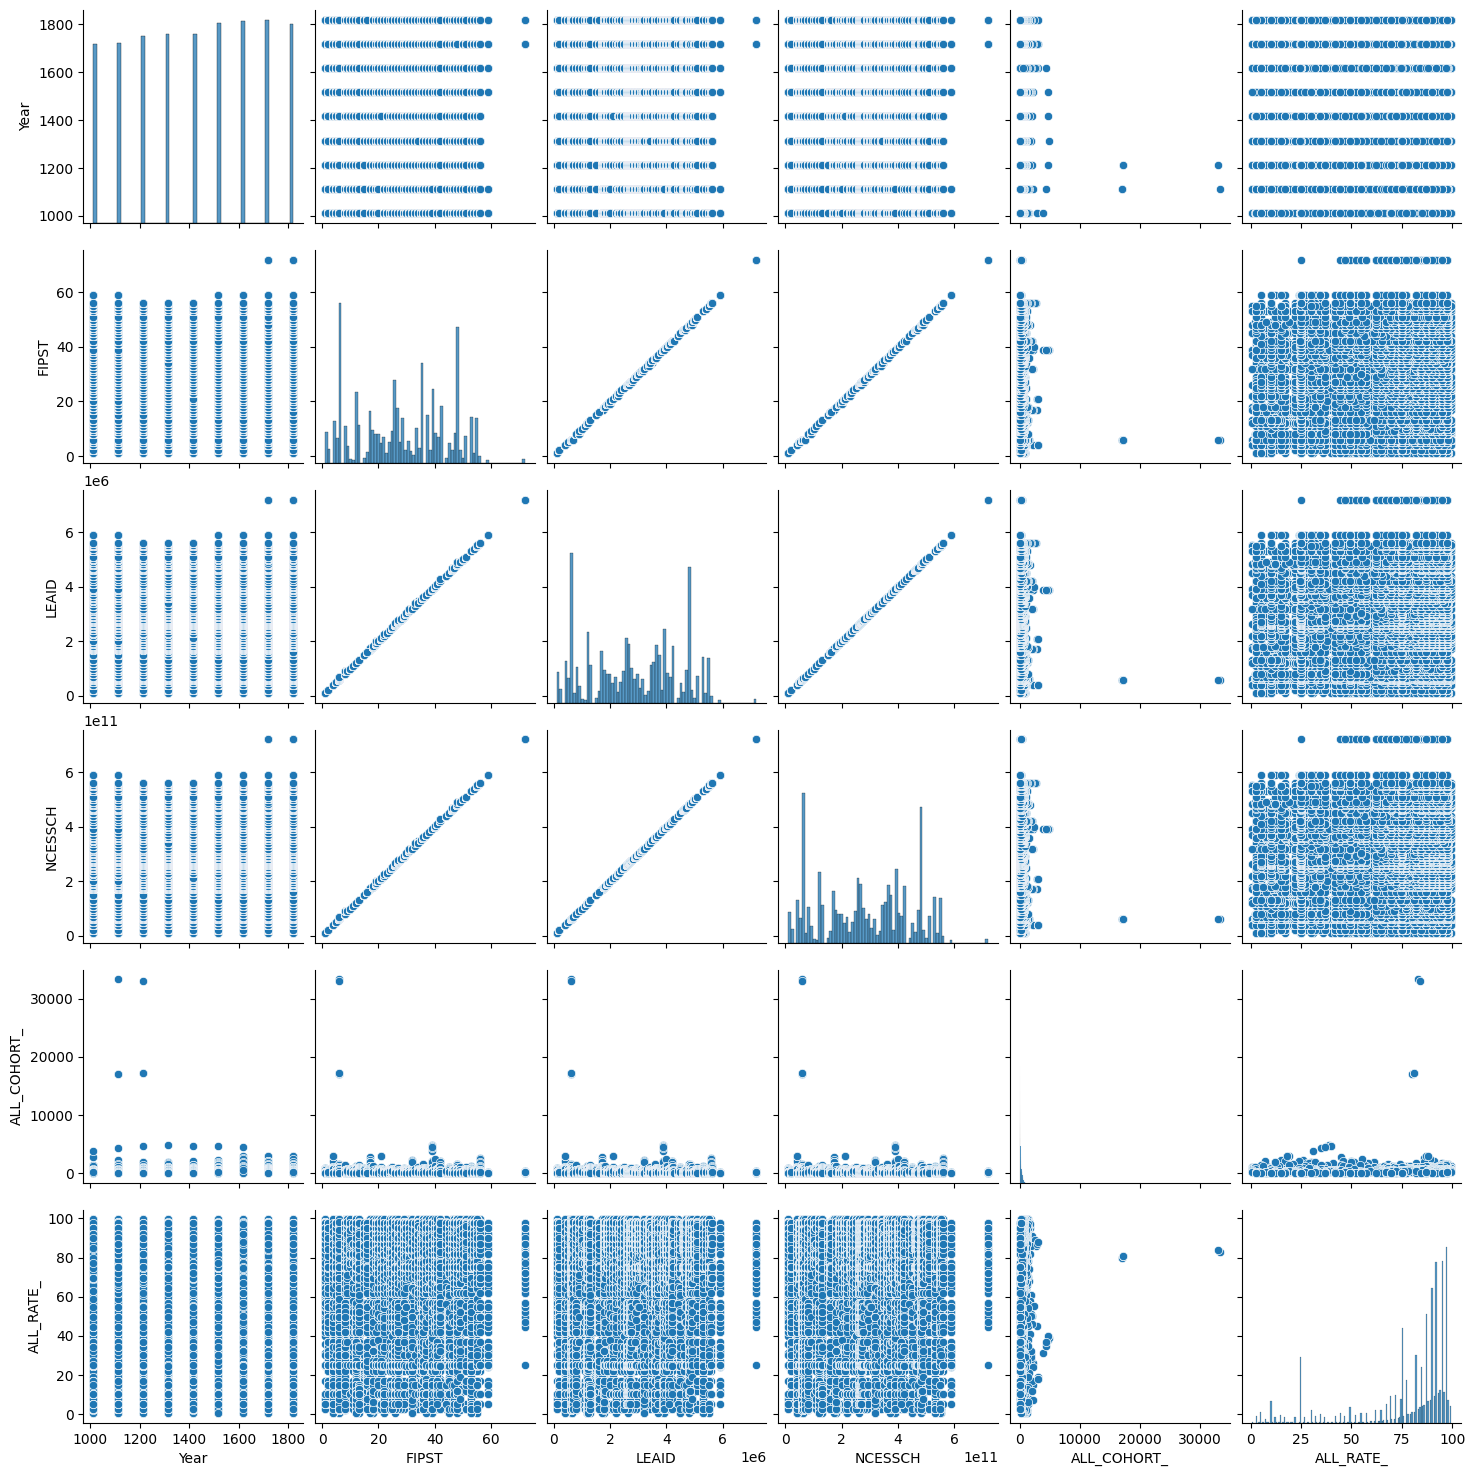

In [238]:
sns.pairplot(big_df)

## Observations from the pairplot
* Rate varies from 0 to 10, which matches expectation
* For two schools in two different years, there are class size outliers of > 10000 students when every other cohort is less than 5000 students.

# Investigate school names 